In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from memory_layers import HashingMemory, ModelEvaluator
from safetensors.torch import load_file
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "Qwen/Qwen2.5-0.5B-Instruct"
hidden_dim = 896
layers_to_replace = [6, 12, 18]
num_samples = 50  # Small sample for quick testing, increase for full eval

/home/sagoyal/research/finetuningmemorylayers/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Evaluate Base Model
print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained(model_id, dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id, dtype=torch.float16)

evaluator = ModelEvaluator(base_model, tokenizer, device=device)
base_results = evaluator.evaluate_triviaqa(num_samples=num_samples)

print("\nBase Model Results:")
print(base_results)

# Free up memory
del base_model
del evaluator
torch.cuda.empty_cache()

Loading Base Model...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Evaluating on TriviaQA (validation, 50 samples)...


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

TriviaQA Accuracy: 10.00%

Base Model Results:
0.1


In [3]:
# 2. Evaluate Fine-tuned Memory Model
print("Loading Fine-tuned Memory Model...")
model = AutoModelForCausalLM.from_pretrained(model_id, dtype=torch.float16).to(device)

# Add memory layers
for idx in layers_to_replace:
    mem_layer = HashingMemory(
        input_dim=hidden_dim, output_dim=hidden_dim, mem_n_keys=128, mem_heads=4,
        mem_knn=16, mem_k_dim=256, mem_v_dim=-1, swilu_projection=True,
        value_fixed_lr=0.001, mem_share_values=False
    )
    model.model.layers[idx].mlp = mem_layer.to(device, dtype=model.dtype)

# Load weights
try:
    state_dict = load_file("./qwen_memory_final/model.safetensors")
except:
    state_dict = torch.load("./qwen_memory_final/pytorch_model.bin", weights_only=False)

model.load_state_dict(state_dict, strict=False)

evaluator = ModelEvaluator(model, tokenizer, device=device)
ft_results = evaluator.evaluate_triviaqa(num_samples=num_samples)

print("\nFine-tuned Model Results:")
print(ft_results)

Loading Fine-tuned Memory Model...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Evaluating on TriviaQA (validation, 50 samples)...


100%|██████████| 50/50 [00:39<00:00,  1.28it/s]

TriviaQA Accuracy: 0.00%

Fine-tuned Model Results:
0.0



Comparison Table:
                    0
Base              0.1
Memory-Augmented  0.0


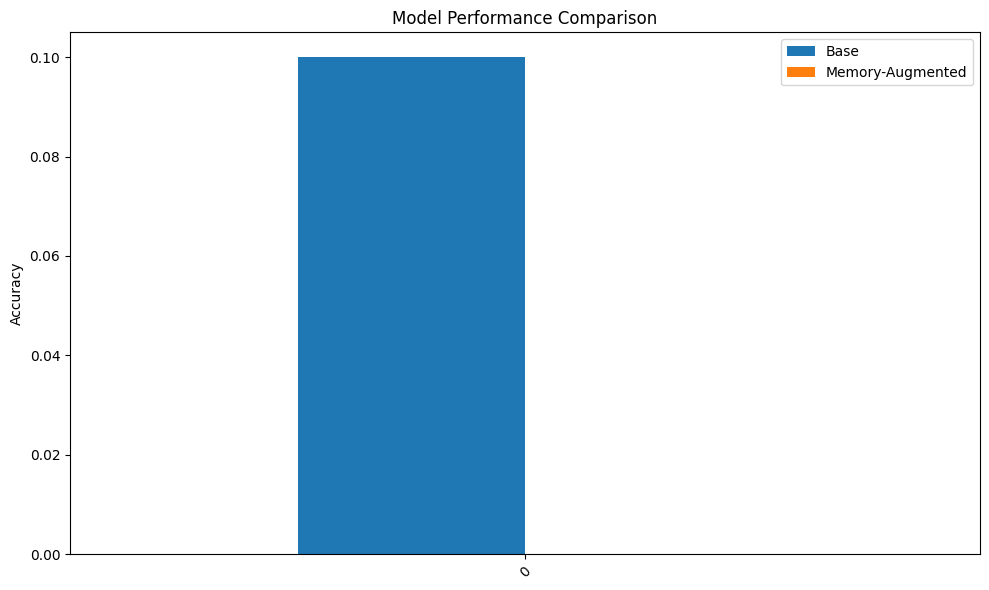

In [4]:
# 3. Compare Results
df = pd.DataFrame([base_results, ft_results], index=['Base', 'Memory-Augmented'])
print("\nComparison Table:")
print(df)

# Plot
df.T.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()